In [1]:
import yfinance as yf 
import numpy as np 
import pandas as pd 
import pandas_datareader.data as web 
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt 
from pandas_datareader.famafrench import get_available_datasets

plt.style.use('bmh')

In [2]:
get_available_datasets()[:5]

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

In [3]:
# equally weighted portfoilio
assets = ["AMZN", "GOOG", "AAPL", "MSFT"]
weights = [1/len(assets) for _ in range(len(assets))]

data = yf.download(assets, period='10y', interval='1d', auto_adjust=True, progress=False)
data = data.Close.resample('M').last().iloc[:-1, :] # resample to monthly
data_ret = np.log(data/data.shift(1)).dropna() # get returns
data_ret.index = data_ret.index.strftime('%Y-%m')
data_ret

,AAPL,AMZN,GOOG,MSFT
Date,,,,
2012-03,0.100102,0.119556,0.036511,0.016250
2012-04,-0.026312,0.135517,-0.058423,-0.007468
2012-05,-0.010760,-0.085437,-0.040471,-0.085994
2012-06,0.010794,0.070010,-0.001361,0.046847
2012-07,0.044803,0.021446,0.087274,-0.037301
...,...,...,...,...
2021-09,-0.070462,-0.055003,-0.087571,-0.068406
2021-10,0.057001,0.026255,0.106695,0.162366
2021-11,0.099919,0.039147,-0.040033,-0.001283


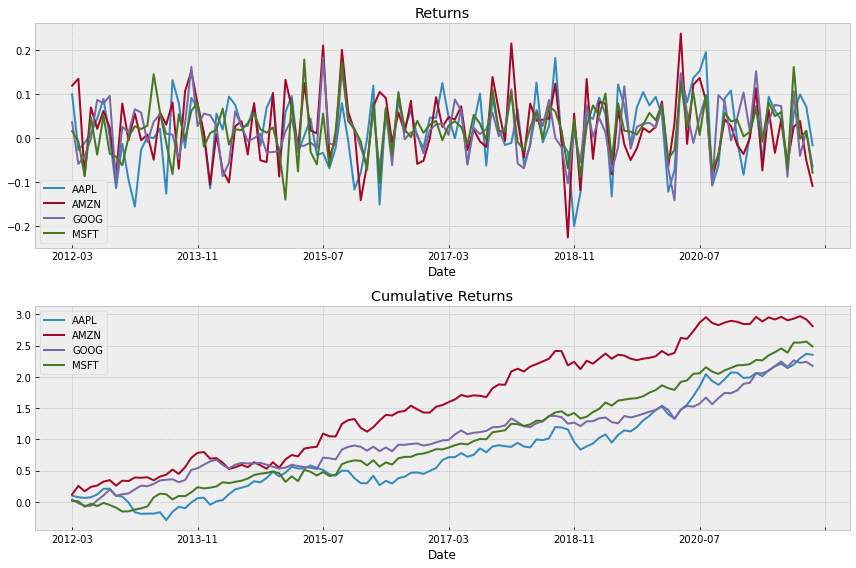

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))

data_ret.plot(ax=ax[0], title='Returns')
data_ret.cumsum().plot(ax=ax[1], title='Cumulative Returns')

plt.tight_layout()
plt.show()

In [5]:
ff_factors = web.DataReader('F-F_Research_Data_Factors', 'famafrench',
                            start=data.index[0], end=data.index[-1])[0]
ff_factors = ff_factors.div(100)
ff_factors.index = ff_factors.index.strftime('%Y-%m')
ff_factors.rename(columns={'Mkt-RF':'MKT'}, inplace=True)

In [6]:
data = data_ret.merge(ff_factors, how='inner', left_index=True, right_index=True)
data.head()

,AAPL,AMZN,GOOG,MSFT,MKT,SMB,HML,RF
Date,,,,,,,,
2012-03,0.100102,0.119556,0.036511,0.016250,0.0311,-0.0066,0.0112,0.0000
2012-04,-0.026312,0.135517,-0.058423,-0.007468,-0.0085,-0.0041,-0.0077,0.0000
2012-05,-0.010760,-0.085437,-0.040471,-0.085994,-0.0619,0.0009,-0.0106,0.0001
2012-06,0.010794,0.070010,-0.001361,0.046847,0.0389,0.0064,0.0059,0.0000
2012-07,0.044803,0.021446,0.087274,-0.037301,0.0079,-0.0272,-0.0012,0.0000


In [7]:
data['returns'] = np.matmul(data[assets].values, weights) # portfolio returns
data['excess_returns'] = data['returns'] - data['RF'] # excess returns
data.head()

,AAPL,AMZN,GOOG,MSFT,MKT,SMB,HML,RF,returns,excess_returns
Date,,,,,,,,,,
2012-03,0.100102,0.119556,0.036511,0.016250,0.0311,-0.0066,0.0112,0.0000,0.068105,0.068105
2012-04,-0.026312,0.135517,-0.058423,-0.007468,-0.0085,-0.0041,-0.0077,0.0000,0.010828,0.010828
2012-05,-0.010760,-0.085437,-0.040471,-0.085994,-0.0619,0.0009,-0.0106,0.0001,-0.055665,-0.055765
2012-06,0.010794,0.070010,-0.001361,0.046847,0.0389,0.0064,0.0059,0.0000,0.031573,0.031573
2012-07,0.044803,0.021446,0.087274,-0.037301,0.0079,-0.0272,-0.0012,0.0000,0.029056,0.029056


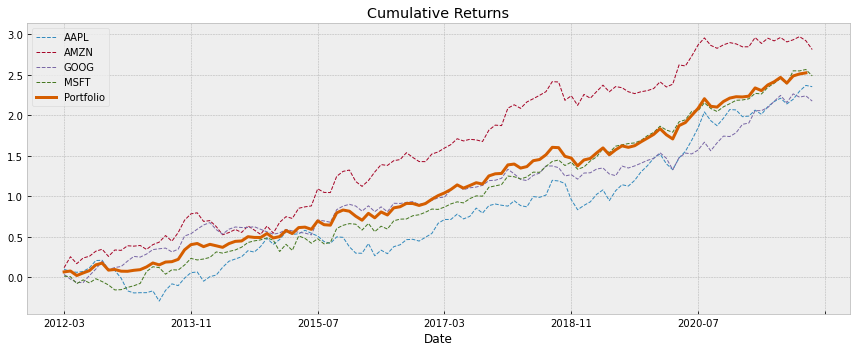

In [8]:
fig, ax = plt.subplots(figsize=(12,5))

data_ret.cumsum().plot(ax=ax, linestyle='--', linewidth=1)
data['returns'].cumsum().plot(ax=ax, label='Portfolio', legend=True, linewidth=3)
ax.set_title('Cumulative Returns')

plt.tight_layout()
plt.show()

In [9]:
def fit_ff_model(data):
    model = smf.ols(formula='excess_returns ~ MKT + SMB + HML', data=data).fit()
    
    return model.params

In [10]:
window = 60
coeffs = []

for start_index in range(len(data) - window + 1):
    end_index = start_index + window
    data_sample = data[start_index:end_index]
    coeff = fit_ff_model(data_sample)
    coeffs.append(coeff)

In [11]:
coeffs_df = pd.DataFrame(coeffs, index=data.index[window-1:])
coeffs_df.head()

,Intercept,MKT,SMB,HML
Date,,,,
2017-02,0.004470,1.188696,-0.627085,-0.595067
2017-03,0.004428,1.172597,-0.606959,-0.620754
2017-04,0.004524,1.175070,-0.601883,-0.630217
2017-05,0.004291,1.185533,-0.606410,-0.628052
2017-06,0.003802,1.199658,-0.630178,-0.636711


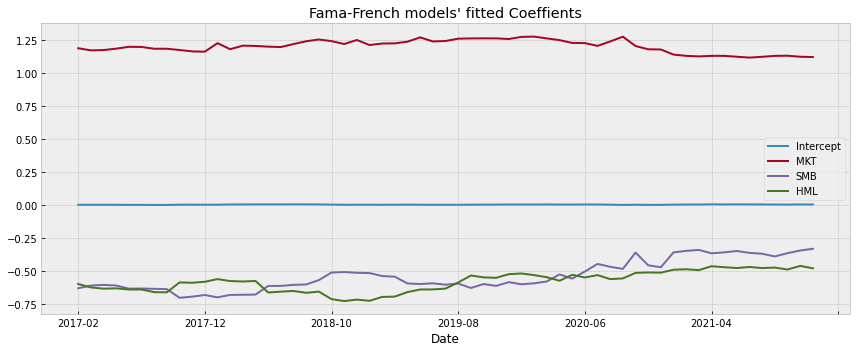

In [12]:
coeffs_df.plot(figsize=(12,5), title="Fama-French models' fitted Coeffients")
plt.tight_layout()
plt.show()
# coefficients are quite consistent